“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on May 8, 2019

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import os
%matplotlib inline

In [2]:
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Data Loading

### Order Info

In [3]:
orders = pd.read_csv('orders.csv')
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')

In [4]:
print(orders.shape)
print(prior.shape)
print(train.shape)

(3421083, 7)
(32434489, 4)
(1384617, 4)


In [5]:
print("Orders:")
print(orders.dtypes)
print("\nPrior:")
print(prior.dtypes)
print("\nTrain:")
print(train.dtypes)

Orders:
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

Prior:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

Train:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object


In [6]:
orders[orders['eval_set']=='prior'].head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [7]:
orders[orders['eval_set']=='train'].head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0


In [8]:
orders[orders['eval_set']=='test'].head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0


In [9]:
# Number of unique customers
print(len(orders['user_id'].unique()))

206209


In [10]:
# Number of unique orders
print(len(orders['order_id'].unique()))

3421083


---
orders.csv contains the historical orders of customers, detailing the order ID per all customers, the customer ID, the order number per that customer, day of the week the order was placed, hour of the day the order was placed, and the number of days since that customer's previous order

Each instance is labeled as train, test, or prior. If the instance is train or test, then the order pertains to that customer's most recent order. The test set will be the set for which this program will aim to predict reordered products. 

---

In [11]:
prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [12]:
train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


---
order_products_prior.csv contains the order details of orders labeled as prior in the orders.csv
order_products_train.csv contains the order details of orders labeled as train in the orders.csv

Information in these files list out all the products in each order, the order in which they were added to the customer's cart, and whether or not the customer had ordered this product in a previous order.

---



**Unfortunately, the number of orders is too much for my notebook to handle. Thus, moving forward, I will be limiting the dataset to 1/4 of the users.**



In [13]:
orders_sample = orders[orders['user_id'] % 4 == 0]
orders_sample.shape

(857100, 7)

In [14]:
# join orders and prior
orders_products = orders_sample.merge(prior, on='order_id', how='inner')
print(orders_products.shape)
orders_products.head(3)

(8113089, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,3343014,4,prior,1,6,11,NaN,36606,1,0
1,3343014,4,prior,1,6,11,NaN,7350,2,0
2,3343014,4,prior,1,6,11,NaN,35469,3,0


### Product Info

In [15]:
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [16]:
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [17]:
aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [18]:
departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


---
products.csv appends the product name, aisle ID, and department ID to each product ID

aisles.csv appends the aisle name to each aisle ID

departments.csv appends the department name to each department ID

---

In [19]:
# join products, aisles, and departments
item_info_df = products.merge(aisles,on='aisle_id').merge(departments,on='department_id')
print(item_info_df.shape)
item_info_df.head(3)

(49688, 6)


,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks


In [20]:
# Number of unique products
print(len(item_info_df['product_id'].unique()))

49688


In [21]:
# Number of unique aisles (a.k.a product types)
print(len(item_info_df['aisle_id'].unique()))

134


In [22]:
# Number of unique departments
print(len(item_info_df['department_id'].unique()))

21


In [23]:
# join item info to orders dataframe
full_df = orders_products.merge(item_info_df, on='product_id', how='inner')
full_df.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,3343014,4,prior,1,6,11,NaN,36606,1,0,Sprouted Multi-Grain Bread,112,3,bread,bakery
1,2077777,168,prior,4,3,14,15.0,36606,7,0,Sprouted Multi-Grain Bread,112,3,bread,bakery
2,893725,184,prior,8,0,22,30.0,36606,2,0,Sprouted Multi-Grain Bread,112,3,bread,bakery


## Data Exploration

### Orders

In [24]:
'''
Are there multiple instances of products per order?
'''
test = full_df.groupby(['order_id','product_name'])['product_id'].count().reset_index()
test[test['product_id'] > 1].count()

order_id        0
product_name    0
product_id      0
dtype: int64

_All orders contain only unique products, no duplicates per order._

In [25]:
'''
Average order size
'''
avgOrderSize = orders_products.groupby(['order_id'])['product_id'].count().reset_index()
avgOrderSize = avgOrderSize['product_id'].value_counts()

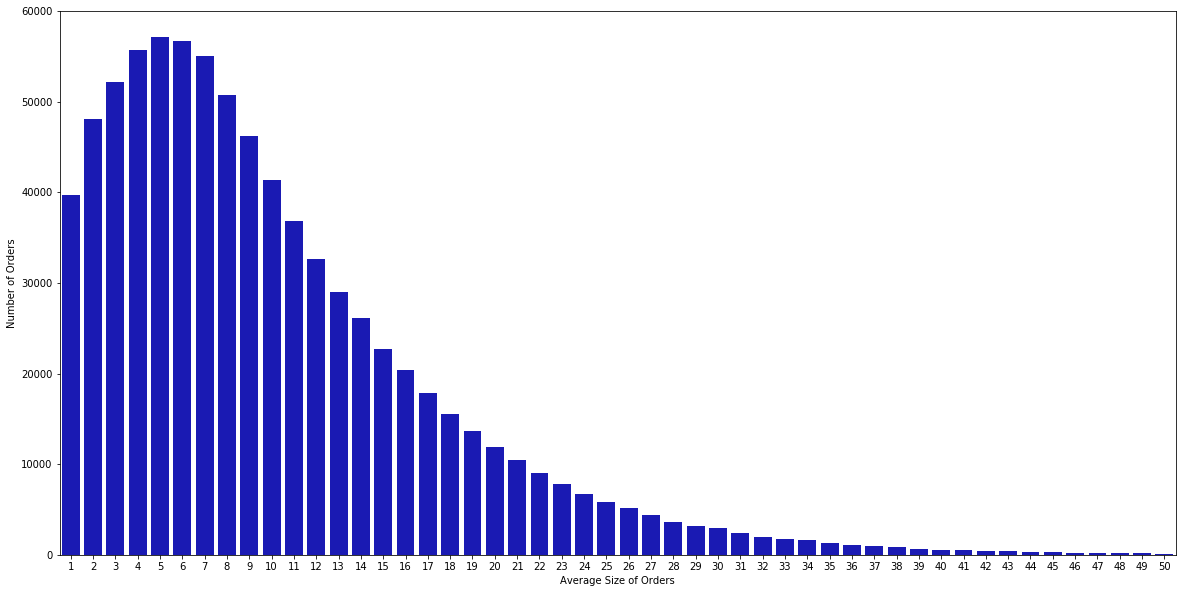

In [26]:
# visualize average order size
plt.figure(figsize=(20,10))
sns.barplot(x=avgOrderSize.index[:50], y=avgOrderSize.values[:50], color='mediumblue')
plt.xlabel('Average Size of Orders')
plt.ylabel('Number of Orders')
plt.show()

In [27]:
'''
Order frequency (days between orders)
'''
orderFreq = orders_products['days_since_prior_order'].value_counts()

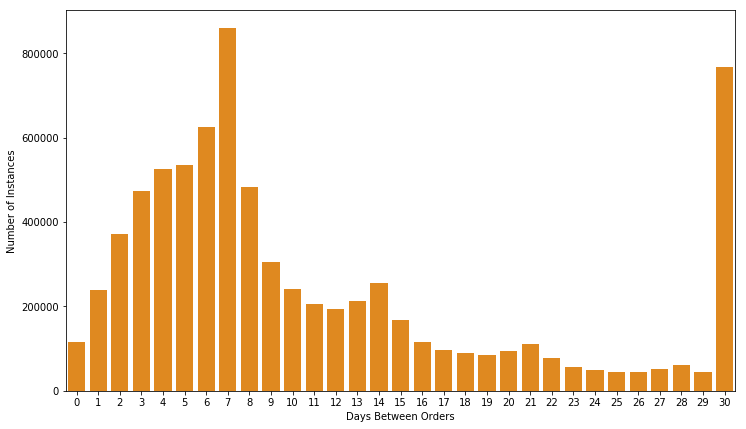

In [28]:
# visualize number of purchases per order frequency
plt.figure(figsize=(12,7))
sns.barplot(x=orderFreq.index.astype('int32'), y=orderFreq.values, color='darkorange')
plt.xlabel('Days Between Orders')
plt.ylabel('Number of Instances')
plt.show()

_Local maximums around the end of week marks (7 days, 14 days, 21 days, and 28 days) as well as at month end_

### Timing

In [29]:
'''
Day of the week
'''
dow = orders_sample.groupby(['order_dow'])['order_id'].count()
dow

order_dow
0    150169
1    147135
2    116708
3    109841
4    107101
5    114005
6    112141
Name: order_id, dtype: int64

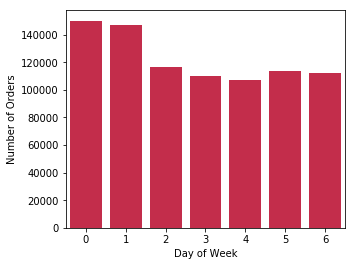

In [30]:
# visualize number of purchases per day of week
plt.figure(figsize=(5,4))
sns.barplot(x=dow.index, y=dow.values, color='crimson')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

In [31]:
'''
Hour of day
'''
hod = orders_sample.groupby(['order_hour_of_day'])['order_id'].count()

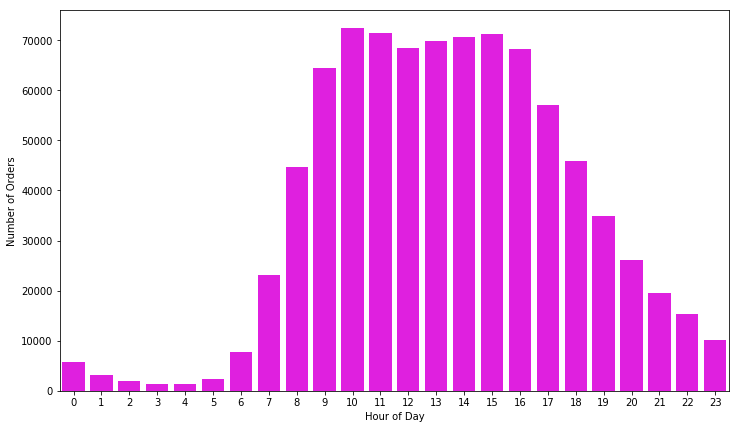

In [32]:
# visualize number of purchases per hour of day
plt.figure(figsize=(12,7))
sns.barplot(x=hod.index, y=hod.values, color='fuchsia')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.show()

In [33]:
'''
Number of orders per hour, day
'''
timing_count = orders_sample.groupby(['order_dow','order_hour_of_day'])['order_number'].count().reset_index()

# pivot
timing_count = timing_count.pivot('order_hour_of_day', 'order_dow', 'order_number')
timing_count.sort_index(ascending=False,inplace=True)

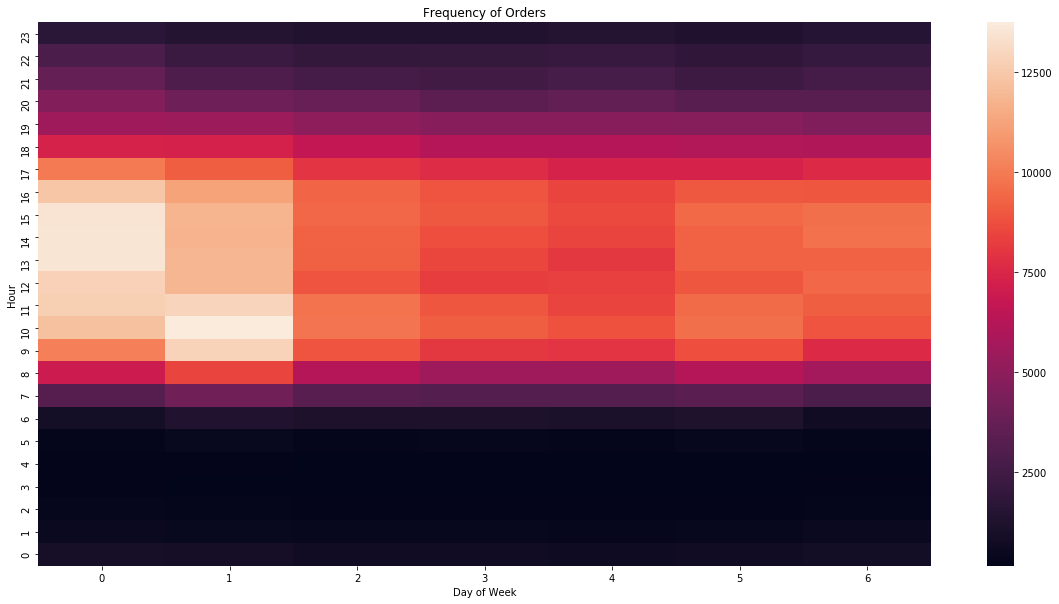

In [34]:
# visualize purchases by hour of day & day of week
plt.figure(figsize=(20,10))
sns.heatmap(timing_count)
plt.title('Frequency of Orders')
plt.ylabel('Hour')
plt.xlabel('Day of Week')
plt.show()

### Products

In [35]:
'''
Top 10 products ordered the most, overall
'''
top_products = full_df.groupby(['product_name','aisle','department'])['product_id'].count().reset_index()
top_products.rename(columns={'product_id':'Number of Times Purchased'}, inplace=True)
top_products = top_products.sort_values(by='Number of Times Purchased',ascending=False)
top_products.head(10)

,product_name,aisle,department,Number of Times Purchased
3475,Banana,fresh fruits,produce,117347
3279,Bag of Organic Bananas,fresh fruits,produce,94968
30161,Organic Strawberries,fresh fruits,produce,65666
27176,Organic Baby Spinach,packaged vegetables fruits,produce,60195
28585,Organic Hass Avocado,fresh fruits,produce,52312
27140,Organic Avocado,fresh fruits,produce,43574
21130,Large Lemon,fresh fruits,produce,37681
40603,Strawberries,fresh fruits,produce,36391
22078,Limes,fresh fruits,produce,35038
30700,Organic Whole Milk,milk,dairy eggs,34402


In [36]:
'''
Top 10 products reordered the most, overall
'''
top_reordered = full_df.groupby(['product_name','aisle','department'])['reordered'].sum().reset_index()
top_reordered.rename(columns={'reordered':'Number of Times Reordered'}, inplace=True)
top_reordered = top_reordered.sort_values(by='Number of Times Reordered',ascending=False)
top_reordered.head(10)

,product_name,aisle,department,Number of Times Reordered
3475,Banana,fresh fruits,produce,98945
3279,Bag of Organic Bananas,fresh fruits,produce,79083
30161,Organic Strawberries,fresh fruits,produce,50965
27176,Organic Baby Spinach,packaged vegetables fruits,produce,46427
28585,Organic Hass Avocado,fresh fruits,produce,41479
27140,Organic Avocado,fresh fruits,produce,33028
30700,Organic Whole Milk,milk,dairy eggs,28526
21130,Large Lemon,fresh fruits,produce,26043
29624,Organic Raspberries,packaged vegetables fruits,produce,25857
40603,Strawberries,fresh fruits,produce,25652


_As expected, top products overall also match up with top reordered products overall_

In [37]:
'''
Popularity ratio of all products, overall
'''
top_products['Total Number of Purchases'] = full_df['product_id'].count()
top_products['popularity ratio'] = top_products['Number of Times Purchased'] / top_products['Total Number of Purchases']
top_products.describe()

,Number of Times Purchased,Total Number of Purchases,popularity ratio
count,47008.000000,47008.0,4.700800e+04
mean,172.589538,8113089.0,2.127297e-05
std,1226.376981,0.0,1.511603e-04
min,1.000000,8113089.0,1.232576e-07
25%,5.000000,8113089.0,6.162881e-07
50%,17.000000,8113089.0,2.095379e-06
75%,72.000000,8113089.0,8.874548e-06
max,117347.000000,8113089.0,1.446391e-02


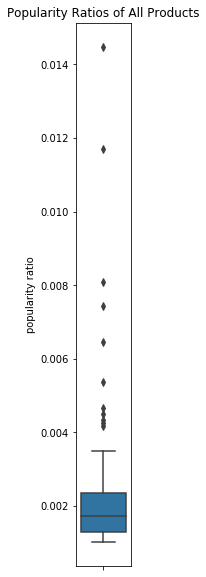

In [38]:
# visualize overall popularity ratios of top 100 products
plt.figure(figsize=(1,10))
sns.boxplot(y='popularity ratio', data=top_products.head(100))
plt.title('Popularity Ratios of All Products')
plt.show()

_The top few products are significantly more popular than the others._

In [39]:
# products with highest reorder ratios per product
top_reordered = top_reordered.merge(top_products[['product_name','Number of Times Purchased']], on='product_name', how='inner')
top_reordered['Reorder Ratio'] = top_reordered['Number of Times Reordered'] / top_reordered['Number of Times Purchased']
top_reordered.sort_values(['Reorder Ratio'], ascending=False, inplace=True)
top_reordered.head(10)

,product_name,aisle,department,Number of Times Reordered,Number of Times Purchased,Reorder Ratio
6812,Thousand Island Salad Snax,fruit vegetable snacks,snacks,83,85,0.976471
12078,Rehab Rojo Energy Tea,energy sports drinks,beverages,31,32,0.968750
12547,Condensed Soup Manhattan Clam Chowder,soup broth bouillon,canned goods,29,30,0.966667
12710,Chicken & Noodles Compleats,instant foods,dry goods pasta,28,29,0.965517
13048,Sparking Water,water seltzer sparkling water,beverages,26,27,0.962963
9479,Morning Oat Crunch Cinnamon Cereal,cereal,breakfast,48,50,0.960000
7768,Traditional Original Amber Lager,beers coolers,alcohol,67,70,0.957143
14502,Strawberry Tarragon Ice Cream,ice cream ice,frozen,21,22,0.954545
7380,Natural Foods Olive Oil Potato Chips Sea Salt,chips pretzels,snacks,73,77,0.948052
15423,"Graduates Grabbers Fruit & Yogurt, Tropical",baby food formula,babies,18,19,0.947368


In [40]:
# number of unique users per product
numUsers_perProduct = full_df.drop_duplicates(subset=['product_name','user_id'])  \
                                              .groupby(['product_name'])['user_id'].count().reset_index()

top_reordered = top_reordered.merge(numUsers_perProduct, on='product_name', how='inner')
top_reordered.rename(columns={'user_id':'Number of Unique Customers'}, inplace=True)
top_reordered.head(10)

,product_name,aisle,department,Number of Times Reordered,Number of Times Purchased,Reorder Ratio,Number of Unique Customers
0,Thousand Island Salad Snax,fruit vegetable snacks,snacks,83,85,0.976471,2
1,Rehab Rojo Energy Tea,energy sports drinks,beverages,31,32,0.968750,1
2,Condensed Soup Manhattan Clam Chowder,soup broth bouillon,canned goods,29,30,0.966667,1
3,Chicken & Noodles Compleats,instant foods,dry goods pasta,28,29,0.965517,1
4,Sparking Water,water seltzer sparkling water,beverages,26,27,0.962963,1
5,Morning Oat Crunch Cinnamon Cereal,cereal,breakfast,48,50,0.960000,2
6,Traditional Original Amber Lager,beers coolers,alcohol,67,70,0.957143,3
7,Strawberry Tarragon Ice Cream,ice cream ice,frozen,21,22,0.954545,1
8,Natural Foods Olive Oil Potato Chips Sea Salt,chips pretzels,snacks,73,77,0.948052,4
9,"Graduates Grabbers Fruit & Yogurt, Tropical",baby food formula,babies,18,19,0.947368,1


In [41]:
top_reordered.describe()

,Number of Times Reordered,Number of Times Purchased,Reorder Ratio,Number of Unique Customers
count,47008.000000,47008.000000,47008.000000,47008.000000
mean,101.841431,172.589538,0.336890,70.748107
std,920.965652,1226.376981,0.245553,335.565767
min,0.000000,1.000000,0.000000,1.000000
25%,1.000000,5.000000,0.111111,3.000000
50%,6.000000,17.000000,0.346154,10.000000
75%,33.000000,72.000000,0.531191,38.000000
max,98945.000000,117347.000000,0.976471,18402.000000


In [42]:
# considering only the top 25 percentile of Number of Unique Customers
top_reordered[top_reordered['Number of Unique Customers'] >= 38].sort_values(by='Reorder Ratio', ascending=False).head(10)

,product_name,aisle,department,Number of Times Reordered,Number of Times Purchased,Reorder Ratio,Number of Unique Customers
134,Half And Half Ultra Pasteurized,milk,dairy eggs,588,671,0.876304,83
135,Whole Organic Omega 3 Milk,milk,dairy eggs,2068,2362,0.875529,294
200,Ultra-Purified Water,water seltzer sparkling water,beverages,341,395,0.863291,54
202,Organic Lactose Free Whole Milk,soy lactosefree,dairy eggs,1832,2125,0.862118,293
206,Organic Whole Milk,milk,dairy eggs,2195,2548,0.861460,353
207,Grassmilk Organic Fat Free Milk,soy lactosefree,dairy eggs,329,382,0.861257,53
263,Organic Reduced Fat Omega-3 Milk,milk,dairy eggs,1123,1317,0.852696,194
270,Organic Homogenized Whole Milk,milk,dairy eggs,759,891,0.851852,132
274,Goat Milk,milk,dairy eggs,1158,1361,0.850845,203
289,"Milk, Organic, Vitamin D",milk,dairy eggs,4058,4790,0.847182,732


_People are apparently consistent with their choice of dairy brands._

In [43]:
'''
Items ordered the most but reordered the least
'''
# count number of purchases per product
purchases = full_df.groupby(['product_name','aisle','department'])['product_id'].count().reset_index()
purchases.rename(columns={'product_id':'Number of Times Purchased'}, inplace=True)

# count number of reorders per product
reordered = full_df.groupby(['product_name','aisle','department'])['reordered'].sum().reset_index()
reordered.rename(columns={'reordered':'Number of Times Reordered'}, inplace=True)

# calculate First Time Purchases and Repurchase Index
purchases_reordered = purchases.merge(reordered[['product_name','Number of Times Reordered']], on='product_name', how='inner')
purchases_reordered['First Time Purchases'] = purchases_reordered['Number of Times Purchased'] - purchases_reordered['Number of Times Reordered']
purchases_reordered['Repurchase Index'] = purchases_reordered['Number of Times Reordered'] / purchases_reordered['Number of Times Purchased']

purchases_reordered.sort_values(by=['Repurchase Index', 'First Time Purchases'], ascending=[True,False], inplace=True)
purchases_reordered[purchases_reordered['Number of Times Purchased'] > 50].head(10)

,product_name,aisle,department,Number of Times Purchased,Number of Times Reordered,First Time Purchases,Repurchase Index
30471,Organic Unsulphured Molasses,honeys syrups nectars,pantry,93,0,93,0.000000
45968,Whole Celery Seed,spices seasonings,pantry,66,0,66,0.000000
17814,Ground Nutmeg,spices seasonings,pantry,133,1,132,0.007519
46268,Wholesome Organic Powdered Sugar,baking ingredients,pantry,79,1,78,0.012658
28529,Organic Ground Coriander,spices seasonings,pantry,60,1,59,0.016667
29491,Organic Poppy Seed,nuts seeds dried fruit,snacks,60,1,59,0.016667
4240,Birthday Candles,baking supplies decor,pantry,57,1,56,0.017544
38009,"Shortening, All-Vegetable",baking ingredients,pantry,90,2,88,0.022222
12438,"Double Superfine Mustard Powder, Original English",spices seasonings,pantry,89,2,87,0.022472
17813,Ground Mustard,spices seasonings,pantry,89,2,87,0.022472


_The items least repurchased are typically pantry items (such as spices seasonings).  
Spice suppliers could greatly benefit if they motivated users to increase spice usage in their cooking._

In [44]:
'''
Number of purchases for all products by hour of day
'''
# group all products for each hour of day
products_byHour = full_df.groupby(['order_hour_of_day','product_name'])['product_id'].count().reset_index()
products_byHour.rename(columns={'product_id':'Number of Times Purchased per Hour'}, inplace=True)

# append total purchases to each product grouped by hour
products_byHour = products_byHour.merge(top_products, on='product_name', how='inner')

# limit to products with more than 1,000 total purchases
products_byHour = products_byHour[products_byHour['Number of Times Purchased'] >= 1000]

In [45]:
# calculate percent of purchases by hour
products_byHour['% of purchases in hour'] = products_byHour['Number of Times Purchased per Hour'] / \
                                                products_byHour['Number of Times Purchased']

# which products had majority of their purchases in either the first half of the day or the second half
# i.e. which products were most time-sensitive
products_byHour['am_pm'] = np.where(products_byHour['order_hour_of_day'] < 12, 'AM', 'PM')
products_byNoon = products_byHour.groupby(['product_name','am_pm'])['% of purchases in hour'].sum().reset_index()
products_byNoon.rename(columns={'% of purchases in hour':'% of purchases in half of day'}, inplace=True)

# 50 most sensitive products (25 of which purchased early, 25 of which purchased late)
early = products_byNoon[products_byNoon['am_pm']=='AM'].sort_values(by='% of purchases in half of day',ascending=False).head(25)
early['time preference'] = 'early'
late = products_byNoon[products_byNoon['am_pm']=='PM'].sort_values(by='% of purchases in half of day',ascending=False).head(25)
late['time preference'] = 'late'

# combine list of 25 early and 25 late products
timesensitive = pd.concat([early, late])[['product_name','time preference']]

# filter products_byHour for timesensitive products
products_byHour = products_byHour.merge(timesensitive, on='product_name', how='inner')

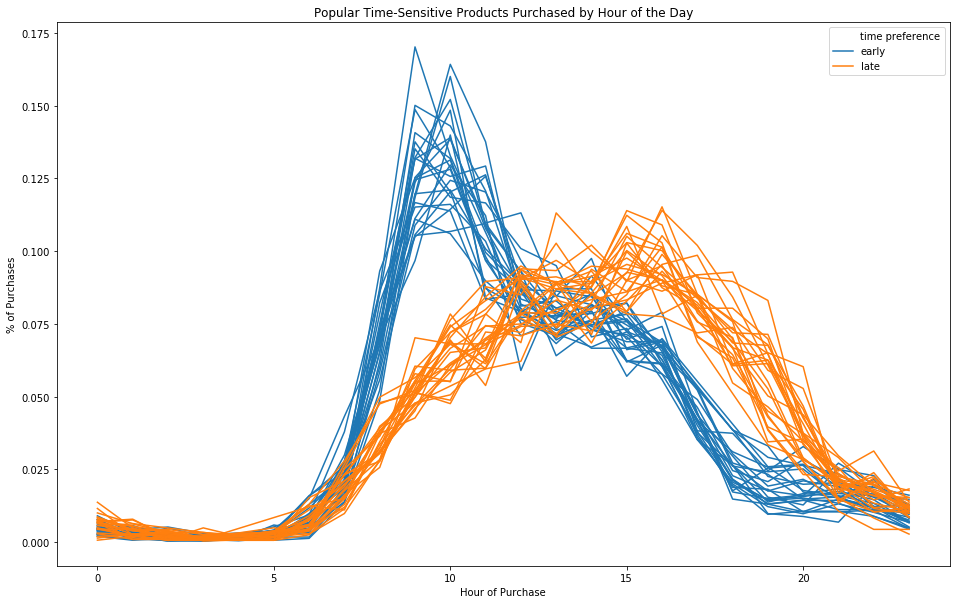

Early Products
['0% Greek Strained Yogurt' 'Apples'
 'Blueberry on the Bottom Nonfat Greek Yogurt' 'Cherrios Honey Nut'
 'Clementines' "Crunchy Oats 'n Honey Granola Bars"
 'Dark Chocolate Nuts & Sea Salt Bars' 'Dried Mangos'
 'Extra Fancy Unsalted Mixed Nuts' 'Fat Free Blueberry Yogurt'
 'Half And Half Cream'
 'Maple Pumpkin Seeds with Sea Salt Chewy with a Crunch Granola Bars'
 'Milk Chocolate Almonds'
 'Non-Fat Greek Yogurt With Strawberries on the Bottom'
 'Oats & Honey Gluten Free Granola' 'Organic Coconut Water'
 'Organic Low Fat Milk' 'Organic Simply Naked Pita Chips'
 'Original Beef Jerky' 'Original Rice Krispies Treats' 'Pink Lady Apples'
 'Popcorn' 'Trail Mix' 'Zen Tea' 'with Crispy Almonds Cereal'] 

Late Products
['Americone Dream® Ice Cream' 'Birthday Cake Light Ice Cream'
 'Blue Cheese Crumbles' 'Cabernet Sauvignon'
 'Caramel Cookie Crunch Gelato' 'Cherry Garcia Ice Cream'
 'Chocolate Chip Cookie Dough Ice Cream'
 'Chocolate Peanut Butter Cup Gelato' 'Extralean Ground Tur

In [46]:
# visualize
plt.figure(figsize=(16,10))
sns.lineplot(x='order_hour_of_day', y='% of purchases in hour', units='product_name', estimator=None, hue='time preference',
             legend='full', data=products_byHour)
plt.title('Popular Time-Sensitive Products Purchased by Hour of the Day')
plt.xlabel('Hour of Purchase')
plt.ylabel('% of Purchases')
plt.show()

print('Early Products')
print(products_byHour[products_byHour['time preference'] == 'early']['product_name'].unique(),'\n')
print('Late Products')
print(products_byHour[products_byHour['time preference'] == 'late']['product_name'].unique())

_Looking at the most time-sensitive products, we can see that the items purchased most heavily during the morning hours are typically healthy items. Meanwhile, the 25 items that are typically purchased in the afternoon and evening are almost all ice cream goods._

In [47]:
# top 10 products purchased for each interval between orders
by_days_btwn = full_df.groupby(['days_since_prior_order','product_name'])['product_id'].count().reset_index()
by_days_btwn = by_days_btwn.sort_values(by=['product_id'],ascending=False).groupby('days_since_prior_order').head(10)
by_days_btwn = by_days_btwn.sort_values(by=['days_since_prior_order','product_id'],ascending=[True,False])

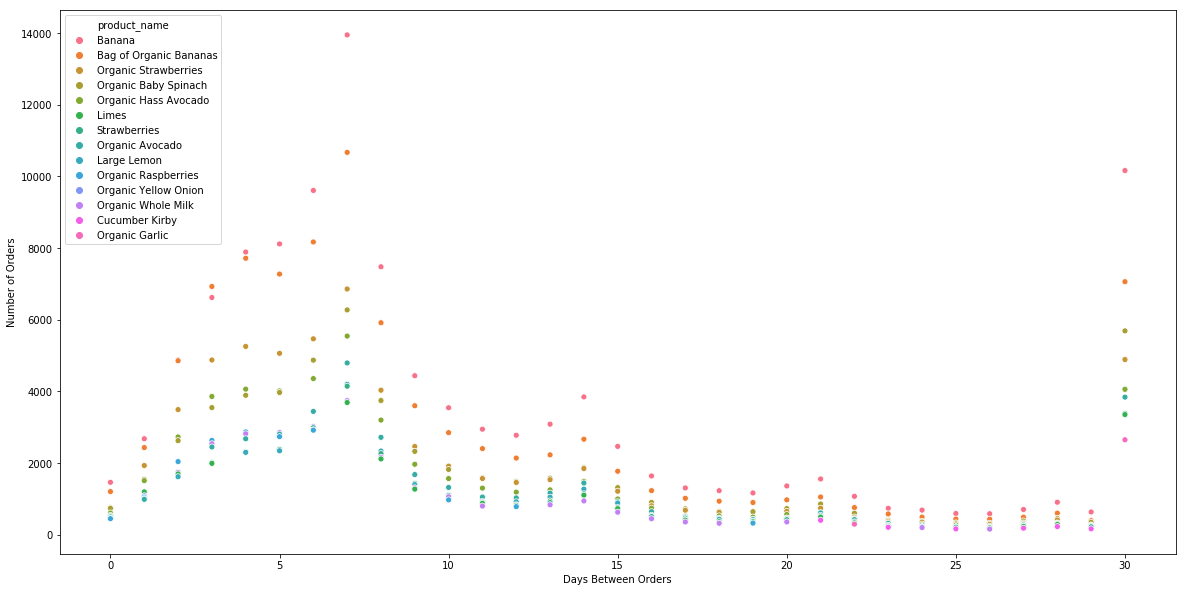

In [48]:
# visualize top products by order frequency
plt.figure(figsize=(20,10))
sns.scatterplot(x='days_since_prior_order', y='product_id', hue='product_name',data=by_days_btwn)
plt.xlabel('Days Between Orders')
plt.ylabel('Number of Orders')
plt.show()

_Very little variation in the top products mix amongst all users across all intervals of orders_

In [49]:
'''
Explore Order Added to Cart
'''
# count number of purchases of each item, grouping by order added to cart
top_products_byOrder = full_df.groupby(['add_to_cart_order','product_id','product_name'])['order_id'].count().reset_index()
top_products_byOrder.rename(columns={'order_id':'Number of Times Purchased (as nth item in cart)'}, inplace=True)

In [50]:
# reordered count and number of total orders
reorder_byOrder = full_df.groupby(['add_to_cart_order'])['reordered'].sum().reset_index()
order_byOrder = full_df.groupby(['add_to_cart_order'])['order_id'].count().reset_index()

# reorder ratio of products by order added to cart
byOrder = reorder_byOrder.merge(order_byOrder, on='add_to_cart_order', how='inner')
byOrder.rename(columns={'reordered':'Number of Times Reordered', 'order_id':'Number of Orders'}, inplace=True)
byOrder['reorder ratio'] = byOrder['Number of Times Reordered'] / byOrder['Number of Orders']

# limit added_to_cart s.t. number of orders > 1000
byOrder = byOrder[byOrder['Number of Orders'] > 1000]

print("Maximum added to cart order (with more than 1000 orders): ", byOrder['add_to_cart_order'].max())
byOrder.head(10)

Maximum added to cart order (with more than 1000 orders):  49


,add_to_cart_order,Number of Times Reordered,Number of Orders,reorder ratio
0,1,546515,805548,0.678439
1,2,517708,765836,0.676004
2,3,472223,717699,0.657968
3,4,424371,665515,0.637658
4,5,376784,609860,0.617820
5,6,331712,552726,0.600138
6,7,290131,496037,0.584898
7,8,252349,440942,0.572295
8,9,219124,390170,0.561612
9,10,189033,343977,0.549551


In [51]:
# limit top_products_byOrder to match byOrder dataframe 
top_products_byOrder = top_products_byOrder[top_products_byOrder['add_to_cart_order'] <= 49]

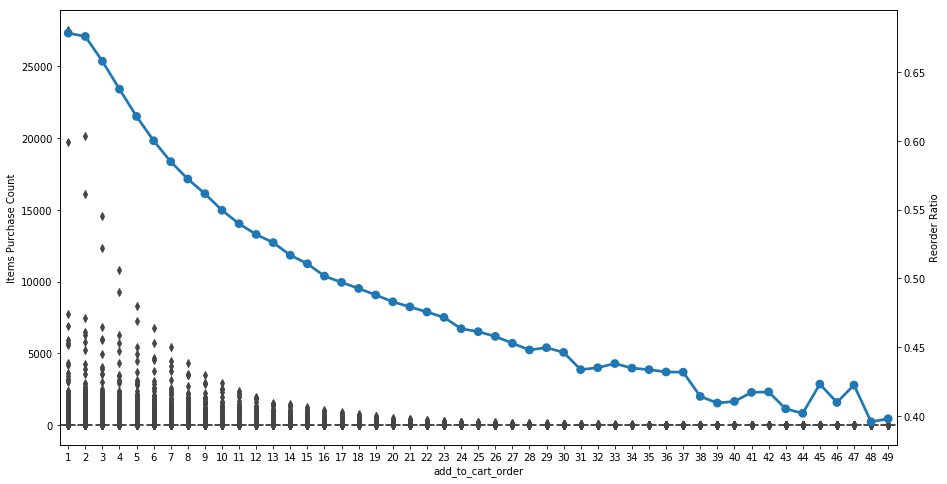

In [52]:
# visualize reorder ratios by order added to cart
# visualize popularity ratios by order added to cart
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()

sns.boxplot(x='add_to_cart_order', y='Number of Times Purchased (as nth item in cart)', data=top_products_byOrder, ax=ax1)
ax1.set_ylabel('Items Purchase Count')

sns.pointplot(x='add_to_cart_order', y='reorder ratio', data=byOrder)
ax2.set_ylabel('Reorder Ratio')

plt.xlabel('add to cart order', fontsize=12)
plt.show()

_As expected, the first items added to a user's cart are items that are typically reordered often. Users become more adventureous with product choices the more items they added.  
Moreover, the boxplots show that users are surprisingly consistent relative to each other for several items for the first few items added to their carts, meaning many users added the same items as the first items to their carts._

### Departments and Aisles

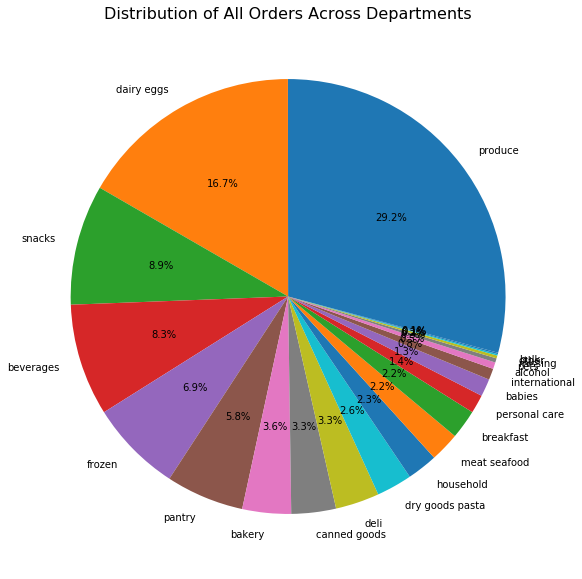

In [54]:
'''
Visualize distributions of orders across departments
'''
departments_count = full_df['department'].value_counts()
labels = (np.array(departments_count.index))
sizes = (np.array((departments_count / departments_count.sum()) * 100))

#color_idxs = np.arange(len(labels)) / len(labels)
#np.random.shuffle(color_idxs)
#c = cm.gist_ncar(color_idxs)

fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, aspect='equal')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=345)
plt.title("Distribution of All Orders Across Departments", fontsize=16)
plt.show()

_Most popular department overall is Produce._

In [55]:
'''
Reorders by aisle
'''
# number of purchases
aisles_purchases = full_df.groupby(['aisle'])['product_id'].count().reset_index()
aisles_purchases.rename(columns={'product_id':'Number of Purchases'}, inplace=True)

# number of reorders
aisles_reorders = full_df.groupby(['aisle'])['reordered'].sum().reset_index()
aisles_reorders.rename(columns={'reordered':'Number of Reorders'}, inplace=True)

# merge
aisles = aisles_purchases.merge(aisles_reorders, on='aisle', how='inner')

# calculate percantage of purchases that are reorders
aisles['% Reorders'] = aisles['Number of Reorders'] / aisles['Number of Purchases'] * 100

aisles.sort_values(by='% Reorders', ascending=False).head(10)

,aisle,Number of Purchases,Number of Reorders,% Reorders
83,milk,220399,172153,78.109701
131,water seltzer sparkling water,213899,156602,73.213058
50,fresh fruits,903467,647350,71.651759
41,eggs,112595,79347,70.471158
119,soy lactosefree,157930,109089,69.074273
96,packaged produce,68708,47342,68.903184
133,yogurt,363755,250450,68.851287
33,cream,78996,53863,68.184465
11,bread,145596,97406,66.901563
110,refrigerated,142994,94875,66.348938


In [56]:
'''
Diversity of aisles (number of unique products)
'''
aisles_diversity = full_df.drop_duplicates(subset=['aisle','product_id']).groupby(['aisle'])['product_id'].count().reset_index()
aisles_diversity.rename(columns={'product_id':'Number of Unique Products'}, inplace=True)

aisles = aisles.merge(aisles_diversity, on='aisle', how='inner')
aisles.sort_values(by='% Reorders', ascending=False).head(10)

,aisle,Number of Purchases,Number of Reorders,% Reorders,Number of Unique Products
83,milk,220399,172153,78.109701,233
131,water seltzer sparkling water,213899,156602,73.213058,338
50,fresh fruits,903467,647350,71.651759,377
41,eggs,112595,79347,70.471158,125
119,soy lactosefree,157930,109089,69.074273,284
96,packaged produce,68708,47342,68.903184,32
133,yogurt,363755,250450,68.851287,992
33,cream,78996,53863,68.184465,155
11,bread,145596,97406,66.901563,545
110,refrigerated,142994,94875,66.348938,640


In [57]:
# take the log of number of purchases for visualization
aisles['Number of Purchases'] = np.log(aisles['Number of Purchases'])

<function matplotlib.pyplot.show(*args, **kw)>

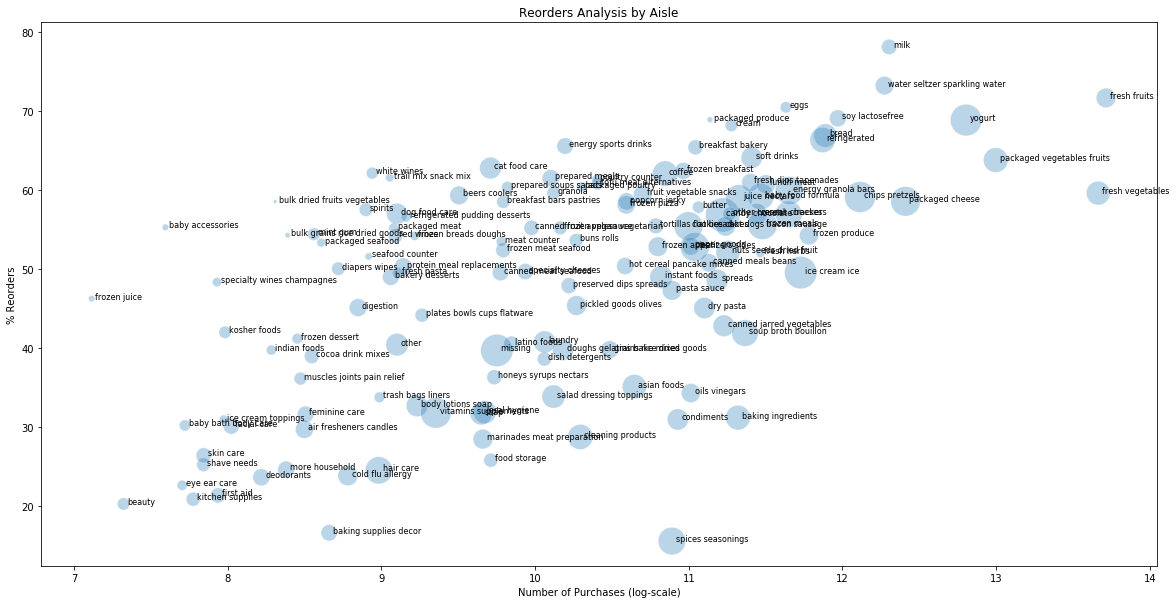

In [58]:
# visualize reorders by aisle
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x='Number of Purchases', y='% Reorders', data=aisles, alpha=.3, s=aisles['Number of Unique Products'])
plt.title('Reorders Analysis by Aisle')
plt.xlabel('Number of Purchases (log-scale)')
plt.ylabel('% Reorders')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.025, point['y'], str(point['val']), fontsize=8)

label_point(aisles['Number of Purchases'], aisles['% Reorders'], aisles['aisle'], plt.gca())  

plt.show

_Generally, the more popular the aisle, the higher the percentage of reorders.  
In addition, the aisles with more purchases tend to have greater diversity of products.   
However, there doesn't appear to be a strong relationship between Reorder rate and Diversity of aisles._

### Customers

In [59]:
'''
Number of unique customers
'''
full_df['user_id'].nunique()

51552

In [60]:
'''
Number of orders per customer
'''
user_numOrders = orders_products.groupby(['user_id'])['order_number'].max().reset_index()
user_numOrders.rename(columns={'order_number':'Number of Orders'}, inplace=True)
numOrders = user_numOrders['Number of Orders'].value_counts()

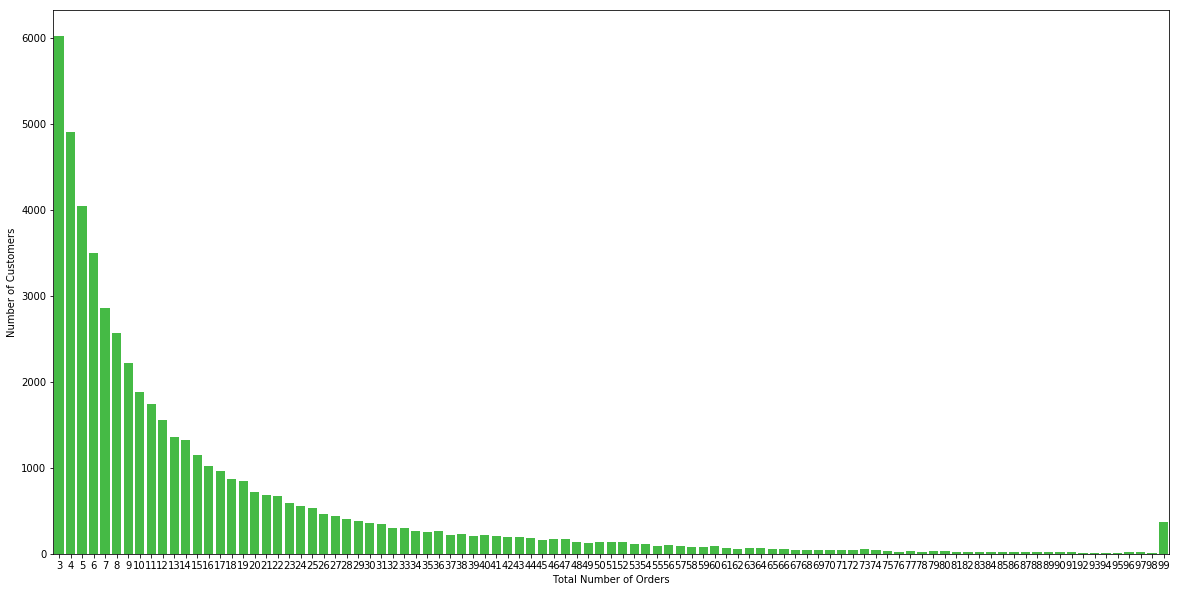

In [61]:
# visualize number of orders by customers
plt.figure(figsize=(20,10))
sns.barplot(x=numOrders.index, y=numOrders.values, color='limegreen')
plt.xlabel('Total Number of Orders')
plt.ylabel('Number of Customers')
plt.show()

_Customers' total number of orders on record range from 3 to 99_

In [62]:
'''
Which users have the most reorders?
'''
# number of reordered products by user
user_numReorders = full_df.groupby(['user_id'])['reordered'].sum().reset_index()
user_numReorders.rename(columns={'reordered':'Number of Reorder Purchases'}, inplace=True)
user_numReorders = user_numReorders.sort_values('Number of Reorder Purchases', ascending=False)
user_numReorders.head(10)

,user_id,Number of Reorder Purchases
50316,201268,3275
32481,129928,3167
46675,186704,2553
1339,5360,2224
35109,140440,2211
18033,72136,2185
1396,5588,2176
5957,23832,2156
13001,52008,1987
43884,175540,1944


In [63]:
'''
Is there a relationship between diversity of basket and reorder ratio?
'''
# count of products purchased per user
user_numProducts = full_df.groupby(['user_id'])['product_id'].count().reset_index()
user_numProducts.rename(columns={'product_id':'Number of Products Ordered'}, inplace=True)

# join number of orders per user with number of products per user
user_orders_products = user_numOrders.merge(user_numProducts, on='user_id', how='inner')

# join in number of reordered products
user_orders_products = user_orders_products.merge(user_numReorders, on='user_id', how='inner')

# calculate reorder ratio
user_orders_products['reorder ratio'] = user_orders_products['Number of Reorder Purchases'] / \
                                            user_orders_products['Number of Products Ordered']

In [64]:
# number of different products ordered per user
user_numUniqueProducts = full_df.groupby(['user_id'])['product_id'].nunique().reset_index()
user_numUniqueProducts.rename(columns={'product_id':'Number of Unique Products Ordered'}, inplace=True)

# join number of unique products to users, number of reordered products, number of orders
user_orders_products = user_orders_products.merge(user_numUniqueProducts, on='user_id', how='inner')

# calculate product diversity ratio
user_orders_products['diversity ratio'] = user_orders_products['Number of Unique Products Ordered'] / \
                                            user_orders_products['Number of Products Ordered']

In [65]:
# reorderers.sort_values(by='reorder ratio',ascending=False, inplace=True)
user_orders_products.sort_values(by='diversity ratio',ascending=False, inplace=True)
user_orders_products.reset_index().drop('index', axis=1, inplace=True)

# sample every 1000th user for analysis
user_orders_products_sample = user_orders_products[user_orders_products.index % 1000 == 0]
user_orders_products_sample.head(10)

,user_id,Number of Orders,Number of Products Ordered,Number of Reorder Purchases,reorder ratio,Number of Unique Products Ordered,diversity ratio
7000,28004,4,27,1,0.037037,26,0.962963
0,4,5,18,1,0.055556,17,0.944444
41000,164004,8,64,6,0.093750,58,0.906250
29000,116004,3,8,1,0.125000,7,0.875000
42000,168004,11,34,5,0.147059,29,0.852941
19000,76004,3,19,3,0.157895,16,0.842105
22000,88004,10,24,4,0.166667,20,0.833333
18000,72004,4,51,9,0.176471,42,0.823529
27000,108004,5,46,9,0.195652,37,0.804348
5000,20004,5,77,17,0.220779,60,0.779221


_By definition, the diversity ratio is the exact inverse of the reorder ratio._

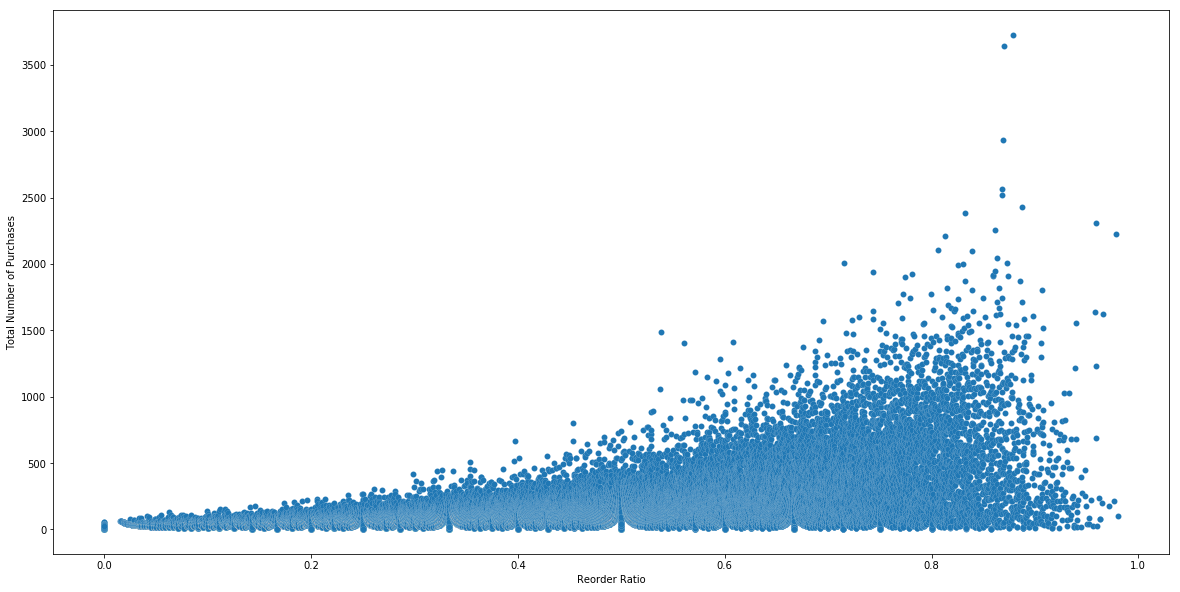

In [66]:
# visualize relationship between reorder ratio and diversity ratio
plt.figure(figsize=(20,10))
sns.scatterplot(x='reorder ratio', y='Number of Products Ordered', data=user_orders_products, linewidth=0.1)
plt.xlabel('Reorder Ratio')
plt.ylabel('Total Number of Purchases')
plt.show()

_Interestingly, users with larger purchase records have higher repurchase ratios.  
This could imply that users tend to settle into their favorite items the more they purchase._

In [67]:
# bucket based on their number of purchase
user_orders_products['number of purchases bucket'] = pd.cut(user_orders_products['Number of Products Ordered'],4,
                                                           labels=['Low', 'Low-Mid', 'Mid-High', 'High'])

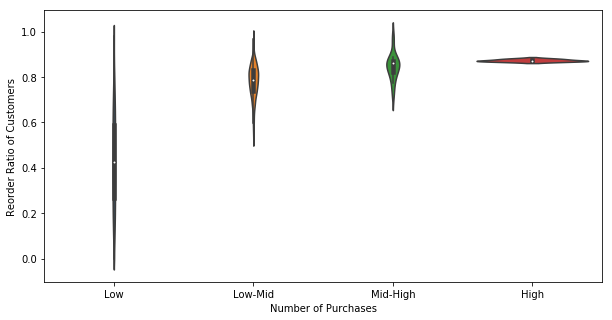

In [74]:
# visualize reorder ratio buckets and number of purchases
plt.figure(figsize=(10,5))
sns.violinplot(x='number of purchases bucket', y='reorder ratio', data=user_orders_products)
plt.xlabel('Number of Purchases')
plt.ylabel('Reorder Ratio of Customers')
plt.show()